Denoising procedure 
=========================

Procedure for denoisng and timeseries extraction of data from LearningBrain experiment.

Confound regression:
- aCompCor
- 24 motion parameters (Satterthwaite et al., 2013)
- outlier scans based on FD (<0.5 mm) and DVARS (< 3 SD)
- task effects + temporal derivatives

Filtering:
- 0.008 - 0.25 Hz


Step 1: Loading libraries
-----------------------

In [24]:
%reset -f
%matplotlib inline

import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import datasets, plotting, input_data, signal, image  

from nilearn.input_data import NiftiLabelsMasker
from nistats.design_matrix import make_design_matrix

import warnings
warnings.filterwarnings('ignore')

from fctools import denoise

Step 2: Preparing paths to files
------------------------------

In [25]:
#--- setting directories for input and output files
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'

#--- selecting subjects who finished the study
groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/behavioral/group_assignment.csv')
trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]['sub']
subs = pd.Series.tolist(trained_subs)
print(f'Sample size: {len(subs)}')

#--- setting sessions and task names
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
#tasks = ['rest']
tasks = ['dualnback']
suffix = '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

Sample size: 46


Step 3: Generating design matrix
--------------------------

In [26]:
#--- settings
t_r = 2
n_scans = 340
events = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv')
frame_times = np.arange(n_scans) * t_r

#--- convolving box car function with HRF
box_hrf = make_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()


Step 4: Denoising data
-----------------------

In [4]:
for sub in subs:
    print(f'Denoising {sub}')
    for ses in sess:
        print(f'- {ses}')
        for task in tasks:
            
            #--- getting directory/file names
            sub_dir = f'{top_dir}{sub}/{ses}/func/'
            sub_name = f'{sub}_{ses}_task-{task}' 
            data = f'{sub_dir}{sub_name}{suffix}'
            
            #--- loading confound data
            confounds_path = f'{sub_dir}{sub_name}_bold_confounds.tsv'
            
            if not os.path.exists(confounds_path):
                print(f'{sub}{ses}{task} does not exist')
            else:
                
                #--- reading confounds table
                confounds = pd.read_csv(confounds_path, delimiter = '\t')
                
                #--- select columns of interest 
                confounds_motion = confounds[confounds.filter(regex = 'X|Y|Z|RotX|RotY|RotZ').columns]
                #confounds_anat = confounds[confounds.filter(regex = 'CSF|WhiteMatter').columns]
                confounds_acompcor = confounds[confounds.filter(regex = 'aCompCor').columns]
                confounds_scrub = confounds[confounds.filter(regex = 'vx-wisestdDVARS|Framewise').columns]

                #--- calculate additional motion parameters (temporal derivatives + quadratic terms)
                confounds_motion =  denoise.temp_deriv(confounds_motion, quadratic = True)
                
                #--- detecting outliers 
                confounds_scrub = denoise.temp_deriv(denoise.outliers_fd_dvars(confounds_scrub, fd = 0.5, dvars = 3), quadratic = False)
                                
                #--- calculating ask effects
                task_effects = denoise.temp_deriv(pd.DataFrame(box_hrf, columns = ['intro', '1-back', '2-back']), quadratic = False)
                
                #--- concatenating columns
                confounds_clean = pd.concat([confounds_acompcor, confounds_motion, confounds_scrub, task_effects], axis = 1)

                #--- saving preprocessed confound file
                confounds_clean.to_csv(f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv', sep = ',', index = False)
                confounds_clean_path = f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv'

                #--- voxel-vise signal denoising
                denoised_nifti = image.clean_img(data, confounds = confounds_clean_path, detrend = True, standardize = False)
                
                #--- saving denoised file
                denoised_nifti.to_filename(f'{sub_dir}{sub_name}{suffix[:-7]}_denoised.nii.gz')

Denoising sub-01
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-02
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-04
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-05
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-06
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-07
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-08
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-10
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-11
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-12
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-13
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-14
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-15
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-16
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-18
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-19
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-20
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-21
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-23
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-24
- ses-1
- ses-2
- ses-3
- ses-4
Denoising sub-25
- s

Step 4: Creating parcellation 
--------------------------------

In [27]:
# -- loading Power ROIs coordinates
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

#--- creating masker file
power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    #smoothing_fwhm = 6, 
    radius = 5,
)

parcellation = power_spheres

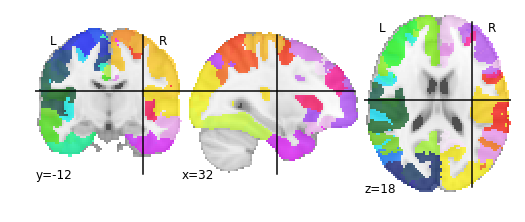

In [22]:
#--- loading Schaefer atlas (400 regions)
atlas_filename = '/home/finc/Dropbox/Projects/LearningBrain/support/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
plotting.plot_roi(atlas_filename)

schaefer = input_data.NiftiLabelsMasker(atlas_filename)

parcellation = schaefer

Step 5: Extracting timeseries
----------------------

In [29]:
roi_n = 264

timeseries_all = np.zeros((len(subs), len(sess), 340, roi_n))
denoising = '_denoised.nii.gz'

for i, sub in enumerate(subs):
    print(f'Extracting timeseries {sub}')
    for j, ses in enumerate(sess):
        print(f'- {ses}')
        for task in tasks:
            
            #--- getting directory/file names
            sub_dir = f'{top_dir}{sub}/{ses}/func/'
            sub_name = f'{sub}_{ses}_task-{task}' 
            denoised_data = f'{sub_dir}{sub_name}{suffix[:-7]}{denoising}'

            # --- extracting timeseries for specified atlas
            timeseries = parcellation.fit_transform(denoised_data, confounds = None)

            # --- filtering data
            timeseries = signal.clean(timeseries, low_pass = 0.25, high_pass = 0.008, t_r = 2, detrend = False, standardize = True)

            # --- saving timeseries in 4D array
            timeseries_all[i, j, :, :] = timeseries
                
np.save(f'{out_dir}LearningBrain_{task}_timeseries_acompcor_24par_008_25_no_smooth_power', timeseries_all)

Extracting timeseries sub-01
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-02
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-04
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-05
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-06
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-07
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-08
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-10
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-11
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-12
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-13
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-14
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-15
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-16
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-18
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries sub-19
- ses-1
- ses-2
- ses-3
- ses-4
Extracting timeseries su